In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL

# -------------------------------------
# Load and Prepare Data
# -------------------------------------
df = pd.read_csv("cleaned_imputed_weather_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Imputed_Wind_Speed_Max_Gust'
target = df[target_col].copy()

# -------------------------------------
# Hampel Filter to Detect Outliers
# -------------------------------------
def detect_outliers_hampel(series, window_size=10, n_sigmas=2.5):
    outliers = []
    k = 1.4826
    for i in range(window_size, len(series) - window_size):
        window = series[i - window_size:i + window_size]
        median = window.median()
        mad = k * np.median(np.abs(window - median))
        if mad == 0:
            continue
        if np.abs(series[i] - median) > n_sigmas * mad:
            outliers.append(i)
    return outliers

outlier_indices = detect_outliers_hampel(target)
print(f"🔍 Detected {len(outlier_indices)} outliers using Hampel filter.")

# -------------------------------------
# Create a copy with NaNs
# -------------------------------------
masked = target.copy()
masked.iloc[outlier_indices] = np.nan

# -------------------------------------
# 1. Linear Interpolation
# -------------------------------------
df['cleaned_linear'] = masked.interpolate(method='linear')

# -------------------------------------
# 2. KNN Imputation
# -------------------------------------
df_knn = df[[target_col]].copy()
df_knn.loc[outlier_indices] = np.nan
imputer = KNNImputer(n_neighbors=5)
df['cleaned_knn'] = imputer.fit_transform(df_knn)

# -------------------------------------
# 3. Rolling Median
# -------------------------------------
mask = pd.Series(False, index=df.index)
mask.iloc[outlier_indices] = True
df['cleaned_rolling'] = target.mask(mask).fillna(target.rolling(window=5, center=True).median())

# -------------------------------------
# 4. Time-aware Interpolation
# -------------------------------------
df_time = df.set_index('Date')
masked_time = df_time[target_col].copy()
masked_time.iloc[outlier_indices] = np.nan
df_time['cleaned_time_interp'] = masked_time.interpolate(method='time')
df = df_time.reset_index()

# -------------------------------------
# 5. Smart Peak-Preserving Imputation
# -------------------------------------
def smart_impute_peaks(series, outlier_idx, window=7):
    series_cleaned = series.copy()
    for i in outlier_idx:
        if i < window or i + window >= len(series):
            continue
        local = series[i - window:i + window + 1].drop(series.index[i])
        upper_quartile = local.quantile(0.75)
        nearby_peaks = local[local >= upper_quartile]
        series_cleaned.iloc[i] = nearby_peaks.mean() if len(nearby_peaks) > 0 else local.median()
    return series_cleaned

df['cleaned_smart_peak'] = smart_impute_peaks(target, outlier_indices)

# -------------------------------------
# 6. STL Decomposition + Residual Imputation
# -------------------------------------
stl_series = target.copy()
stl_series.iloc[outlier_indices] = np.nan
stl_series.index = df['Date']  # Needed for STL

stl_result = STL(stl_series, period=30, robust=True).fit()
residual = stl_result.resid
residual_interp = residual.interpolate(method='linear')

# Reconstruct: trend + seasonal + cleaned residual
df['cleaned_stl'] = (stl_result.trend + stl_result.seasonal + residual_interp).values

# -------------------------------------
# 7. Spline Interpolation
# -------------------------------------
df['cleaned_spline'] = masked.interpolate(method='spline', order=3)


🔍 Detected 262 outliers using Hampel filter.


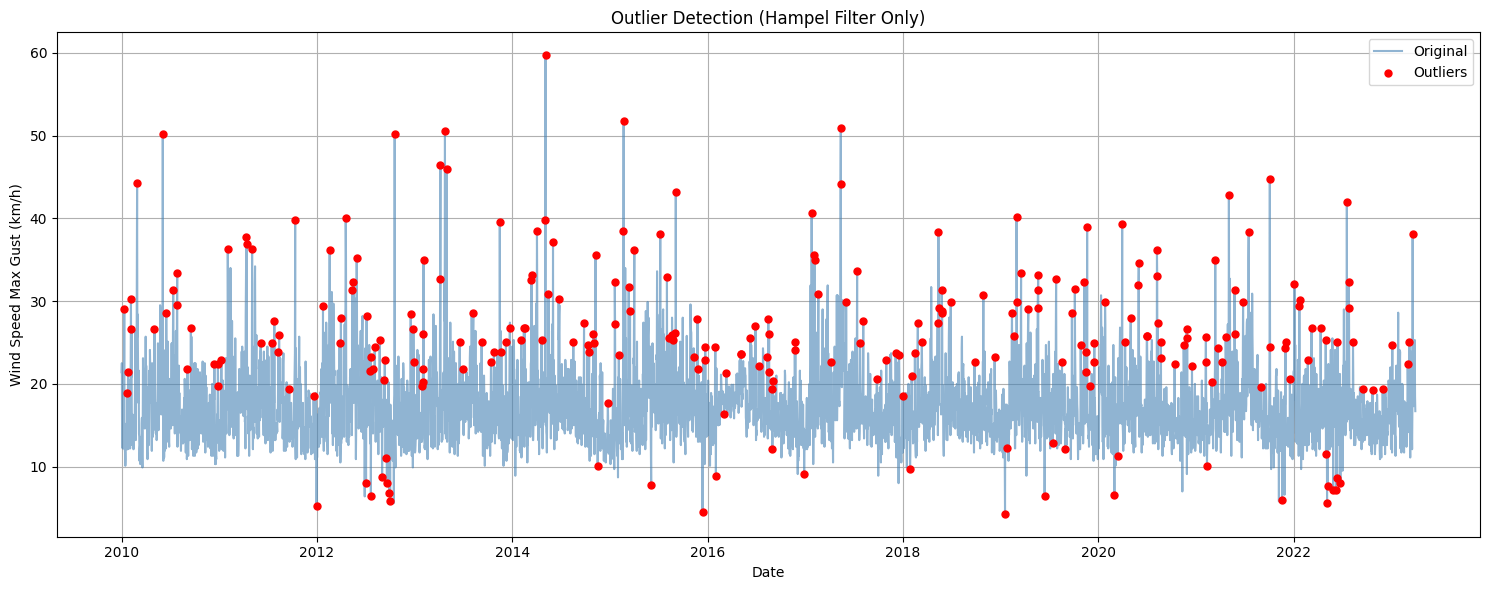

In [41]:
import matplotlib.pyplot as plt

# 📌 Ensure these are defined:
# - df['Date'] – datetime column
# - df[target_col] – original signal
# - outlier_indices – list of Hampel-detected outlier positions

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df['Date'], df[target_col], label='Original', alpha=0.6, color='steelblue')

# Plot outliers
plt.scatter(df.loc[outlier_indices, 'Date'], df.loc[outlier_indices, target_col],
            color='red', label='Outliers', s=25, zorder=5)

plt.title("Outlier Detection (Hampel Filter Only)")
plt.xlabel("Date")
plt.ylabel("Wind Speed Max Gust (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


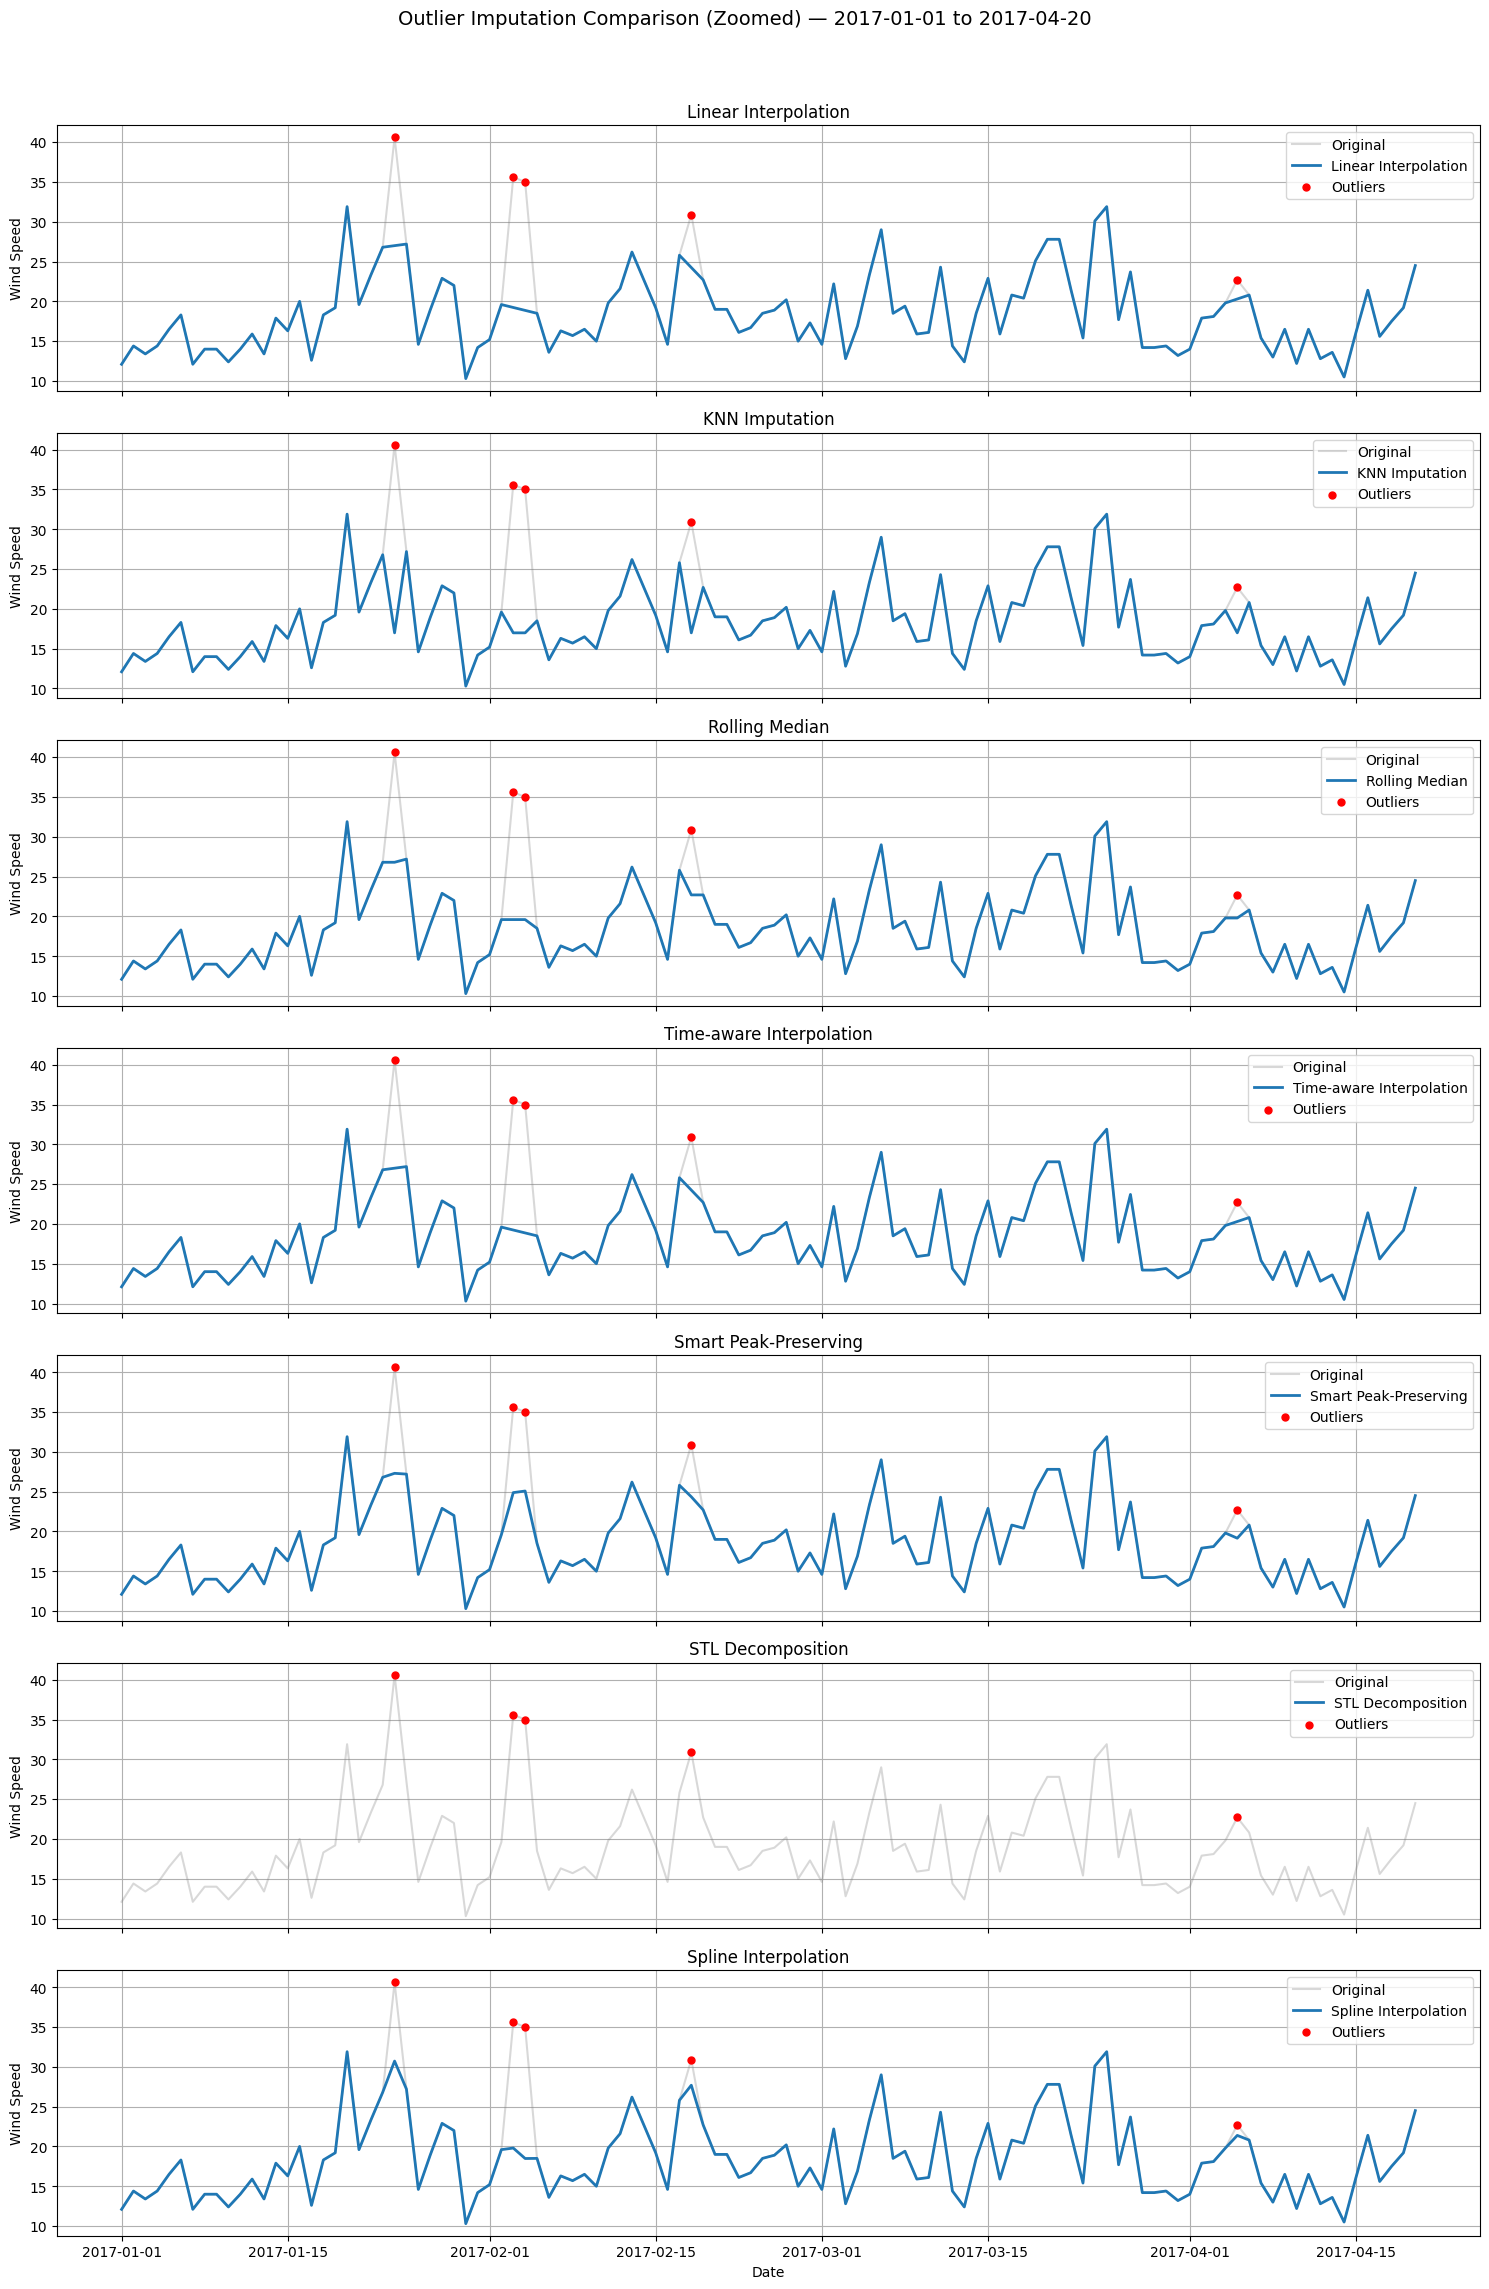

In [42]:
import matplotlib.pyplot as plt

# -------------------------------
# Setup
# -------------------------------
start_date = '2017-01-01'
end_date = '2017-04-20'
zoom_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Method names to plot
methods = {
    "cleaned_linear": "Linear Interpolation",
    "cleaned_knn": "KNN Imputation",
    "cleaned_rolling": "Rolling Median",
    "cleaned_time_interp": "Time-aware Interpolation",
    "cleaned_smart_peak": "Smart Peak-Preserving",
    "cleaned_stl": "STL Decomposition",
    "cleaned_spline": "Spline Interpolation"
}

n_rows = len(methods)
fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3.2 * n_rows), sharex=True)

# -------------------------------
# Plot each method
# -------------------------------
for ax, (col, title) in zip(axes, methods.items()):
    ax.plot(zoom_df['Date'], zoom_df[target_col], label='Original', alpha=0.3, color='gray')
    ax.plot(zoom_df['Date'], zoom_df[col], label=title, linewidth=2)

    zoom_outliers = zoom_df.index.intersection(outlier_indices)
    ax.scatter(zoom_df.loc[zoom_outliers, 'Date'],
               zoom_df.loc[zoom_outliers, target_col],
               color='red', label='Outliers', s=25, zorder=5)

    ax.set_ylabel("Wind Speed")
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc='upper right')

# -------------------------------
# Final layout
# -------------------------------
plt.xlabel("Date")
plt.suptitle(f"Outlier Imputation Comparison (Zoomed) — {start_date} to {end_date}", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


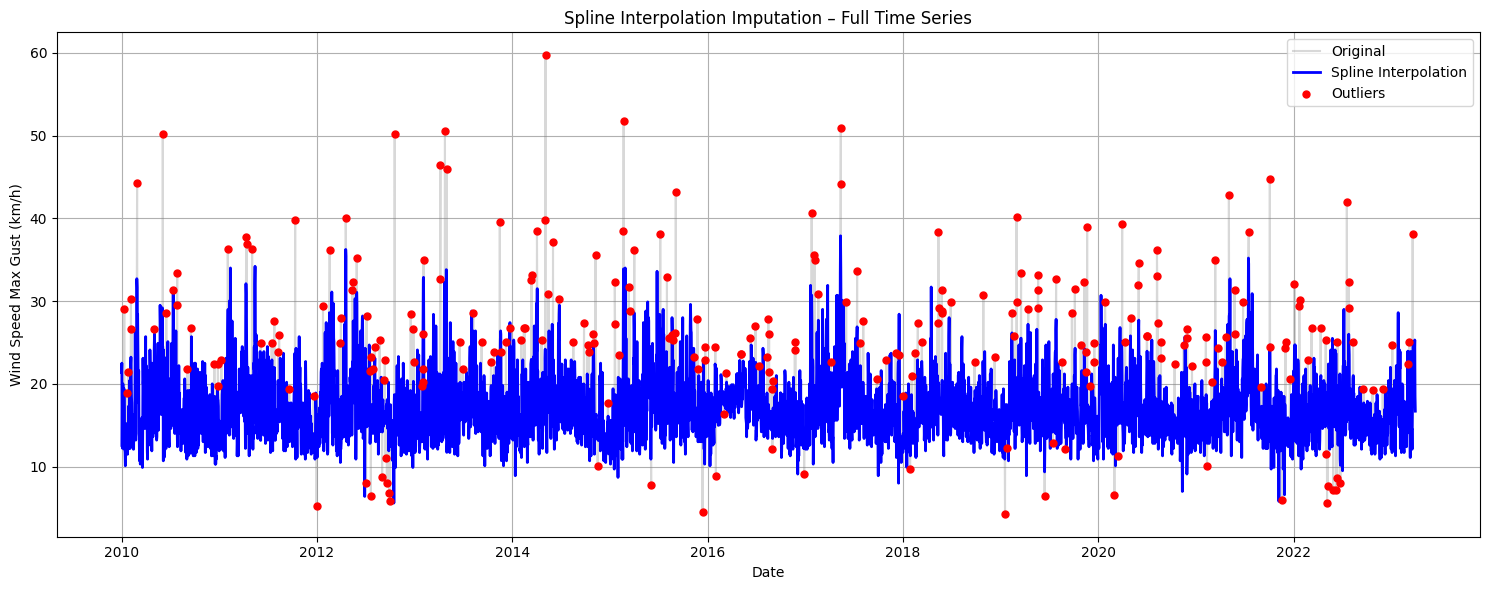

In [44]:
import matplotlib.pyplot as plt

# -------------------------------
# Plot Spline Imputation (Full Data)
# -------------------------------
plt.figure(figsize=(15, 6))

# Plot original
plt.plot(df['Date'], df[target_col], label='Original', alpha=0.3, color='gray')

# Plot spline interpolation result
plt.plot(df['Date'], df['cleaned_spline'], label='Spline Interpolation', linewidth=2, color='blue')

# Highlight detected outliers
plt.scatter(df.loc[outlier_indices, 'Date'],
            df.loc[outlier_indices, target_col],
            color='red', label='Outliers', s=25, zorder=5)

plt.title("Spline Interpolation Imputation – Full Time Series")
plt.xlabel("Date")
plt.ylabel("Wind Speed Max Gust (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

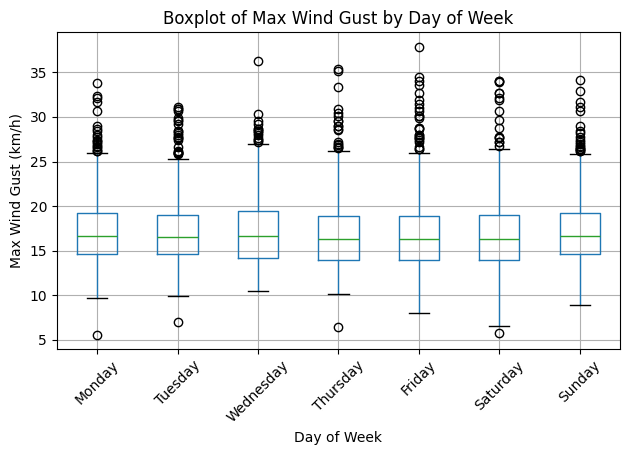

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Date is datetime and extract weekday names
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday_Name'] = df['Date'].dt.day_name()

# Optional: sort weekdays in natural order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday_Name'] = pd.Categorical(df['Weekday_Name'], categories=weekday_order, ordered=True)

# Plot boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column='cleaned_spline', by='Weekday_Name')
plt.title('Boxplot of Max Wind Gust by Day of Week')
plt.suptitle('')
plt.xlabel('Day of Week')
plt.ylabel('Max Wind Gust (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='Weekday_Name', ylabel='cleaned_spline'>

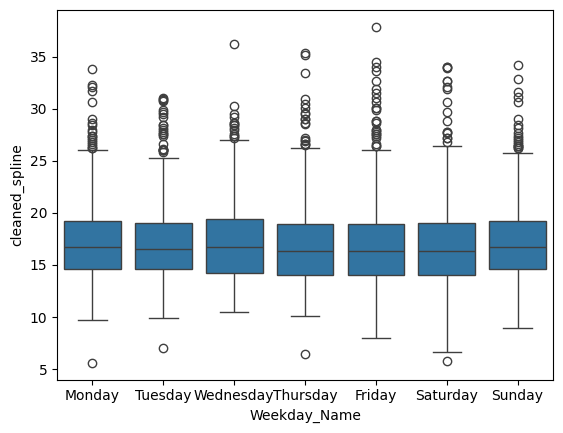

In [45]:
import seaborn as sns
sns.boxplot(data=df, x='Weekday_Name', y='cleaned_spline', order=weekday_order)


<Figure size 1200x600 with 0 Axes>

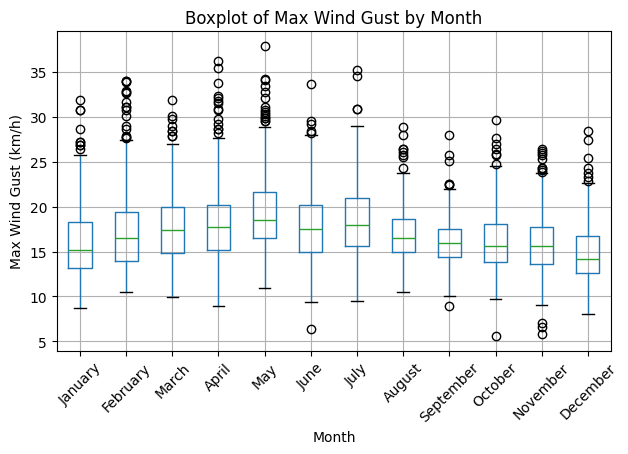

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract month name
df['Month_Name'] = df['Date'].dt.month_name()

# Optional: order months properly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

# Plot boxplot
plt.figure(figsize=(12, 6))
df.boxplot(column='cleaned_spline', by='Month_Name')
plt.title('Boxplot of Max Wind Gust by Month')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Max Wind Gust (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
